In [1]:
%%capture
!pip install pvlib


In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import interpolate

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging(logging_level="ERROR")


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Physics.SemiConductor import ShockleyDiode
    
from pvlib.ivtools.utils import astm_e1036
from pvlib.ivtools.sde import fit_sandia_simple

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

from api_calls import *
url = "https://nomad-hzb-se.de/nomad-oasis/api/v1"
token = get_token(url, name="michael.goette@helmholtz-berlin.de")

Cache? Y/N N


Passwort: 



 ········


In [3]:
def simulate_circuit_sd(params, V):
    circuit = Circuit('Diode Characteristic Curve')
    circuit.model('SolarCellJunction', 'D', IS=params["IS_I"]@u_A, N=float(params["N"]), BV=5@u_V)
    #circuit.model('SolarCellJunction', 'D', IS=params["IS_I"]@u_A, N=1.5, BV=5@u_V)
    
    circuit.V('input', circuit.gnd, 'out', 10@u_V)
    circuit.R('Cu1', 2, circuit.gnd, params["Cu1_R"]@u_Ω)
    circuit.I('L1', 'in', 2, params["L1_I"]@u_A)
    circuit.R('ITO1', 'in', 'out', params["IT01_R"]@u_Ω) # not required for simulation
    circuit.R('Sh1', 'in', 2, params["Sh1_R"]@u_Ω)
    circuit.D(1, 'in', 1, model='SolarCellJunction')
    circuit.R('C1', 1, 2, params["C1_R"]@u_Ω)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    analysis = simulator.dc(Vinput=slice(-V[-1],-V[0],V[1]-V[0]))
    
    I_sim = np.array(analysis["Vinput"])
    
    return I_sim

def simulate_circuit_sd_simple(params, V):
    circuit = Circuit('Diode Characteristic Curve2')
    circuit.model('SolarCellJunction', 'D', IS=params["IS_I"]@u_A, N=float(params["N"]), BV=5@u_V)

    circuit.V('input', circuit.gnd, 'out', 10@u_V)
    circuit.R('S1', 'in', 'out', params["S1_R"]@u_Ω)
    circuit.I('L1', 'in', circuit.gnd, params["L1_I"]@u_A)
    circuit.R('Sh1', 'in', circuit.gnd, params["Sh1_R"]@u_Ω)
    circuit.D(1, 'in', circuit.gnd, model='SolarCellJunction')
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    analysis = simulator.dc(Vinput=slice(-V[-1],-V[0],V[1]-V[0]))
    
    I_sim = np.array(analysis["Vinput"])
    
    return I_sim


def simulate_circuit_dd(params, V):
    circuit = Circuit('Two Diode Network')


    circuit.model('Diode1', 'D', IS=params["IS_I"]@u_A, N=float(params["N"]), BV=5@u_V)
    circuit.model('Diode2', 'D', IS=params["IS2_I"]@u_A, N=float(params["N2"]), BV=5@u_V)

    circuit.V('input', circuit.gnd, 'out', 10@u_V)
    
    circuit.R('S1', 'in', 'out', params["S1_R"]@u_Ω)
    #circuit.R('S1', 'in', 1, params["S1_R"]@u_Ω)
    circuit.I('L1', 'in', circuit.gnd, params["L1_I"]@u_A)
    circuit.R('Sh1', 'in', circuit.gnd, params["Sh1_R"]@u_Ω)
    circuit.D(1, 'in', circuit.gnd, model='Diode1')
    
    circuit.R('S2', 1, 'out', params["S2_R"]@u_Ω)
    circuit.I('L2', 1, circuit.gnd, params["L2_I"]@u_A)
    circuit.R('Sh2', 1, circuit.gnd, params["Sh2_R"]@u_Ω)
    circuit.D(2, 1, circuit.gnd, model='Diode2')
    
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    analysis = simulator.dc(Vinput=slice(-V[-1],-V[0],V[1]-V[0]))
    
    I_sim = np.array(analysis["Vinput"])
    
    return I_sim

def simulate_circuit_td(params, V):
    circuit = Circuit('Two Diode Network')


    circuit.model('Diode1', 'D', IS=params["IS_I"]@u_A, N=float(params["N"]), BV=5@u_V)
    circuit.model('Diode2', 'D', IS=params["IS2_I"]@u_A, N=float(params["N2"]), BV=5@u_V)
    circuit.model('Diode3', 'D', IS=params["IS3_I"]@u_A, N=float(params["N3"]), BV=5@u_V)

    circuit.V('input', circuit.gnd, 'out', 10@u_V)
    
    #circuit.R('S1', 'in', 'out', params["S1_R"]@u_Ω)
    circuit.R('S1', 'in', 'out', params["S1_R"]@u_Ω)
    circuit.I('L1', 'in', circuit.gnd, params["L1_I"]@u_A)
    circuit.R('Sh1', 'in', circuit.gnd, params["Sh1_R"]@u_Ω)
    circuit.D(1, 'in', circuit.gnd, model='Diode1')
    
    circuit.R('S2', 1, 'out', params["S2_R"]@u_Ω)
    circuit.I('L2', 1, circuit.gnd, params["L2_I"]@u_A)
    circuit.R('Sh2', 1, circuit.gnd, params["Sh2_R"]@u_Ω)
    circuit.D(2, 1, circuit.gnd, model='Diode2')
    
    circuit.R('S3', 2, 'out', params["S3_R"]@u_Ω)
    circuit.I('L3', 2, circuit.gnd, params["L3_I"]@u_A)
    circuit.R('Sh3', 2, circuit.gnd, params["Sh3_R"]@u_Ω)
    circuit.D(3, 2, circuit.gnd, model='Diode3')
    
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    analysis = simulator.dc(Vinput=slice(-V[-1],-V[0],V[1]-V[0]))
    
    I_sim = np.array(analysis["Vinput"])
    
    return I_sim


In [4]:
jv_data["jv_curve"][6].get("cell_name")

NameError: name 'jv_data' is not defined

{'voc': 1.1440916205651086, 'isc': 0.0187157, 'vmp': 0.9057325713337343, 'imp': 0.01706434295468921, 'pmp': 0.01545573122247135, 'ff': 0.721809638097474, 'mp_fit': Polynomial([ 0.01522562,  0.00146623, -0.00185096, -0.00147289, -0.00050447], domain=[0.7 , 1.02], window=[-1.,  1.], symbol='x')}
0.018755893512021515 6.551915423646976e-09 2.427402288605664 2634.5149079883363 0.07726010364220255


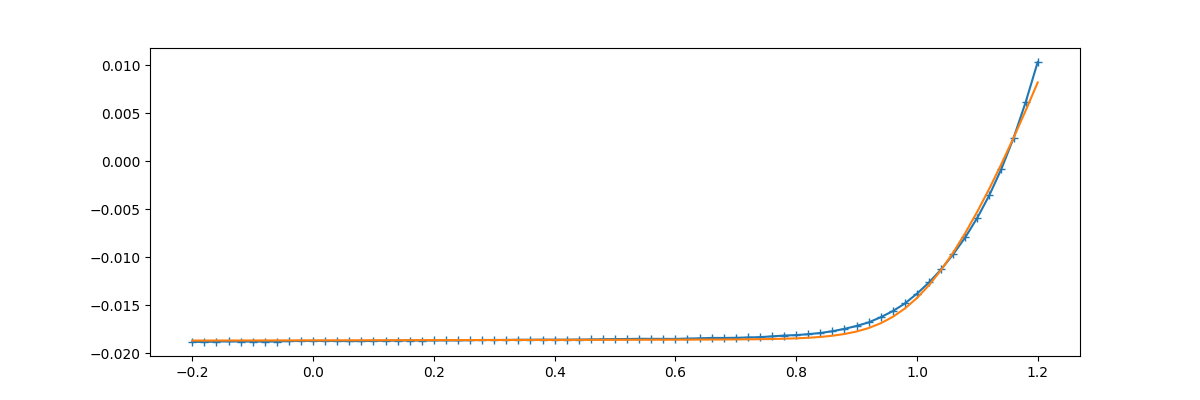

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 71
    # variables        = 5
    chi-square         = 1.0273e-05
    reduced chi-square = 1.5565e-07
    Akaike info crit   = -1108.15518
    Bayesian info crit = -1096.84178
[[Variables]]
    IS_I:   2.3061e-12 +/- 2.9025e-12 (125.86%) (init = 1e-10)
    N:      1.94860854 +/- 0.00198790 (0.10%) (init = 1)
    L1_I:  -0.01866626 +/- 8.9869e-05 (0.48%) (init = -0.01875589)
    S1_R:   4.82994313 +/- 0.15315657 (3.17%) (init = 2.427402)
    Sh1_R:  9010.03698 +/- 13620.1111 (151.17%) (init = 2634.515)
[[Correlations]] (unreported correlations are < 0.100)
    C(L1_I, Sh1_R) = +0.8003
    C(N, Sh1_R)    = -0.3872
    C(S1_R, Sh1_R) = +0.3497
    C(IS_I, Sh1_R) = -0.2448
    C(IS_I, N)     = +0.2295
    C(N, L1_I)     = -0.1995
    C(L1_I, S1_R)  = +0.1640
    C(IS_I, S1_R)  = -0.1443
    C(IS_I, L1_I)  = -0.1113
[ 1.28805669e-04  1.53849227e-04  1.04382368e-04  1.01061342e-04
  1.113

In [5]:
import numpy as np
from lmfit import Minimizer, Parameters, create_params, report_fit
from scipy.interpolate import UnivariateSpline
plt.close()
entry_id = "XOuG2e-usRigsYx8qY5-YNjm47dQ"
jv_data = get_entry_data(url, token, entry_id)

#V = np.flip(np.array(jv_data["jv_curve"][3]["voltage"]))
#I = np.flip(-1* np.array(jv_data["jv_curve"][3]["current_density"])/1000)
V = np.array(jv_data["jv_curve"][8]["voltage"])
I = -1* np.array(jv_data["jv_curve"][8]["current_density"])/1000
res = astm_e1036(V,I)
print(res)
I_L,I_0,R_s,R_sh,nNsVth = fit_sandia_simple(V,I,v_oc=res["voc"],i_sc=res["isc"],v_mp_i_mp=(res["vmp"],res["imp"]),vlim=0.4,ilim=0.1)
print(I_L,I_0,R_s,R_sh,nNsVth)

# define objective function: returns the array to be minimized
def sd(params, x, data):
    V = x
    I = data
    I_sim = simulate_circuit_sd(params, V)
    return I-np.flip(I_sim)

def sd2(params, x, data):
    V = x
    I = data
    I_sim = np.flip(simulate_circuit_sd_simple(params, V))
    
    I_sim_2d = np.gradient(np.gradient(I_sim, V), V)
    I_2d = np.gradient(np.gradient(I, V), V)
    alpha = 1.
    beta = 0.0
    return alpha * np.abs((I-I_sim)) + beta * np.abs((I_sim_2d - I_2d))


# create a set of Parameters
params = Parameters()
params.add('IS_I', value=I_0, min=0, max=1e-10)
params.add('N', value=1., min=0.66, max = 2)

params.add('L1_I', value=-I_L , min=-1,max=0, vary=True)
params.add('S1_R', value=np.abs(R_s), min=0, max=100, vary=True)
params.add('Sh1_R', value=R_sh, min=0, max=20000)


I_neg = -I

plt.figure(figsize=(12,4))
plt.plot(V, I_neg, '+-')

# do fit, here with the default leastsq algorithm
minner = Minimizer(sd2, params, fcn_args=(V, I_neg), max_nfev=5000)
result = minner.minimize(method="leastsq")


# try to plot results
import matplotlib.pyplot as plt
I_fit2 = np.flip(simulate_circuit_sd_simple(result.params, V))
plt.plot(V,  I_fit2)
plt.show()

I_fit2_2d = np.gradient(np.gradient(I_fit2, V), V)
I_neg_2d = np.gradient(np.gradient(I_neg, V), V)
plt.figure(figsize=(12,4))
plt.plot(V, I_neg_2d, '+-')
plt.plot(V, I_fit2_2d)
plt.show()

# write error report
report_fit(result)#, correl_mode='table')
print(I_fit2-I_neg)
print(np.linalg.norm(np.flip(simulate_circuit_sd_simple(result.params, V))-I_neg))

In [6]:
def dd(params, x, data):
    V = x
    I = data
    I_sim = np.flip(simulate_circuit_dd(params, V))
    
    I_sim_2d = np.gradient(np.gradient(I_sim, V), V)
    I_2d = np.gradient(np.gradient(I, V), V)
    alpha = 1.0
    beta = 0.0

    return alpha * np.abs((I-I_sim)) + beta * np.abs((I_sim_2d - I_2d))

def td(params, x, data):
    V = x
    I = data
    I_sim = np.flip(simulate_circuit_td(params, V))
    
    I_sim_2d = np.gradient(np.gradient(I_sim, V), V)
    I_2d = np.gradient(np.gradient(I, V), V)
    alpha = 1.0
    beta = 0.5

    return alpha * np.abs((I-I_sim)) + beta * np.abs((I_sim_2d - I_2d))



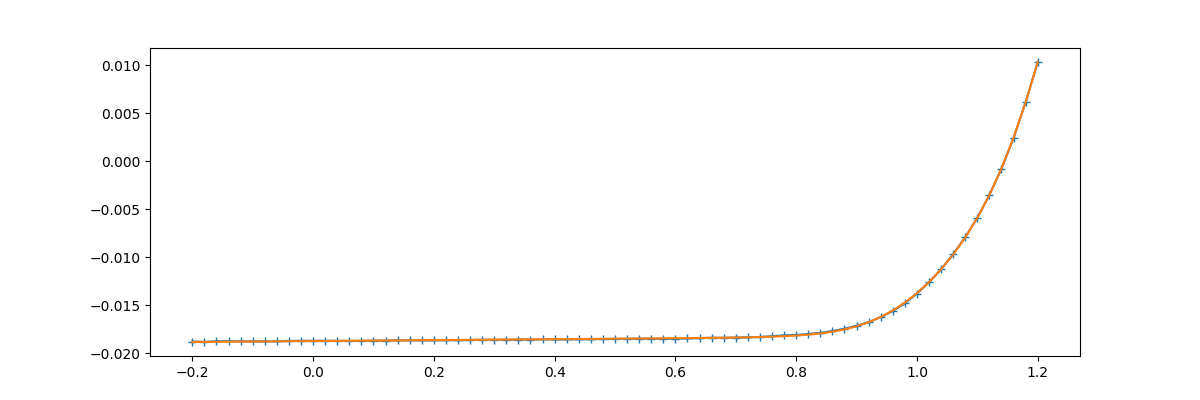

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3000
    # data points      = 71
    # variables        = 10
    chi-square         = 8.2294e-08
    reduced chi-square = 1.3491e-09
    Akaike info crit   = -1440.87064
    Bayesian info crit = -1418.24384
##  Warning: uncertainties could not be estimated:
    IS_I:   at initial value
    IS_I:   at boundary
    N:      at boundary
    IS2_I:  at initial value
    IS2_I:  at boundary
[[Variables]]
    IS_I:   1.2000e-12 (init = 2.306081e-12)
    N:      2.00000000 (init = 1.948609)
    L1_I:  -0.01841158 (init = -0.01866626)
    S1_R:   9.34999395 (init = 4.829943)
    Sh1_R:  2305.33272 (init = 9010.037)
    L2_I:  -4.1228e-04 (init = -0.0001)
    S2_R:   2.41263019 (init = 2.427402)
    Sh2_R:  17357.4856 (init = 2634.515)
    N2:     1.99540581 (init = 1.948609)
    IS2_I:  1.2425e-12 (init = 2.306081e-12)
0.0002868699793518572
0.003205163138897327
0.0002868699793518572


In [9]:
plt.close()
params = result.params.copy()
params.add('L2_I', value=-1e-4, min=-1,max=0, vary=True)
params.add('S2_R', value=np.abs(R_s), min=0, max=100, vary=True)
params.add('Sh2_R', value=R_sh, min=0, max=20000)
params.add('N2', value=params["N"].value, min=0.66, max=2)
params.add('IS2_I', value=params["IS_I"].value, min=0, max=1e-10)

I_neg = -I
plt.figure(figsize=(12,4))
plt.plot(V, I_neg, '+-')

# do fit, here with the default leastsq algorithm
minner = Minimizer(dd, params, fcn_args=(V, I_neg), max_nfev=3000)
result2 = minner.minimize(method="leastsq")

# try to plot results
import matplotlib.pyplot as plt
I_fit2 = np.flip(simulate_circuit_dd(result2.params, V))
plt.plot(V,  I_fit2)
plt.show()

I_fit2_2d = np.gradient(np.gradient(I_fit2, V), V)
I_neg_2d = np.gradient(np.gradient(I_neg, V), V)
plt.figure(figsize=(12,4))
plt.plot(V, I_neg_2d, '+-')
plt.plot(V, I_fit2_2d)
plt.show()

# write error report
report_fit(result2)#, correl_mode='table')
print(np.linalg.norm(np.abs((I+I_fit2))))
print(np.linalg.norm(sd2(result.params, V,I_neg)))
print(np.linalg.norm(dd(result2.params, V,I_neg)))


In [11]:
result2.params

Parameters([('IS_I', <Parameter 'IS_I', value=1.2000186548086711e-12, bounds=[0:1e-10]>), ('N', <Parameter 'N', value=1.999999997190105, bounds=[0.66:2]>), ('L1_I', <Parameter 'L1_I', value=-0.018411581311896796, bounds=[-1:0]>), ('S1_R', <Parameter 'S1_R', value=9.349993954203384, bounds=[0:100]>), ('Sh1_R', <Parameter 'Sh1_R', value=2305.3327175620307, bounds=[0:20000]>), ('L2_I', <Parameter 'L2_I', value=-0.0004122802860304642, bounds=[-1:0]>), ('S2_R', <Parameter 'S2_R', value=2.4126301872223808, bounds=[0:100]>), ('Sh2_R', <Parameter 'Sh2_R', value=17357.48559502138, bounds=[0:20000]>), ('N2', <Parameter 'N2', value=1.9954058113476174, bounds=[0.66:2]>), ('IS2_I', <Parameter 'IS2_I', value=1.2424645519709843e-12, bounds=[0:1e-10]>)])

In [ ]:
plt.close()
params = result2.params.copy()
params.add('L3_I', value=-1e-8, min=-1,max=0, vary=True)
params.add('S3_R', value=np.abs(R_s), min=0, max=100, vary=True)
params.add('Sh3_R', value=R_sh, min=0, max=20000)
params.add('N3', value=params["N"].value, min=0.66, max=2)
params.add('IS3_I', value=params["IS_I"].value, min=0, max=1e-10)

I_neg = -I
plt.figure(figsize=(12,4))
plt.plot(V, I_neg, '+-')

# do fit, here with the default leastsq algorithm
minner = Minimizer(td, params, fcn_args=(V, I_neg), max_nfev=3000)
result3 = minner.minimize(method="leastsq")

# try to plot results
import matplotlib.pyplot as plt
I_fit2 = np.flip(simulate_circuit_td(result3.params, V))
plt.plot(V,  I_fit2)
plt.show()

I_fit2_2d = np.gradient(np.gradient(I_fit2, V), V)
I_neg_2d = np.gradient(np.gradient(I_neg, V), V)
plt.figure(figsize=(12,4))
plt.plot(V, I_neg_2d, '+-')
plt.plot(V, I_fit2_2d)
plt.show()

# write error report
report_fit(result3)#, correl_mode='table')
print(np.linalg.norm(np.abs((I-I_fit))))
print(np.linalg.norm(sd2(result.params, V,I_neg)))
print(np.linalg.norm(dd(result2.params, V,I_neg)))
print(np.linalg.norm(td(result3.params, V,I_neg)))


In [50]:
plt.close()

/home/a2853/miniconda3/envs/doe/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


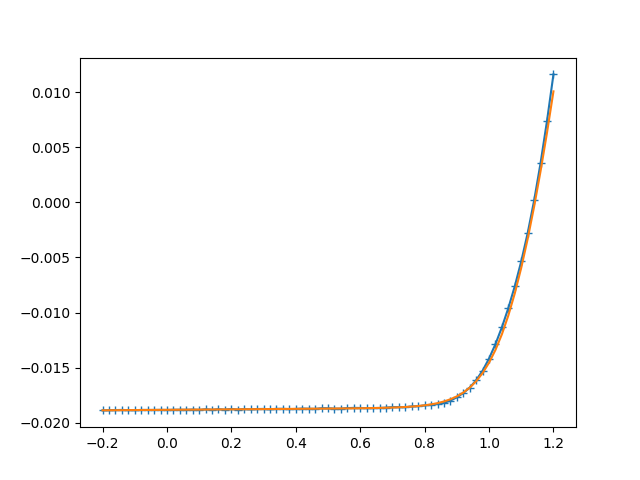

0.002599712089680774


In [32]:
from scipy.special import lambertw
import matplotlib.pyplot as plt
def zz(V,I_L,I_0,R_s,R_sh,nNsVth):
    c = nNsVth*(1+R_s/R_sh)
    return R_s*I_0/c*np.exp((I_L+I_0)*R_s/c+1/nNsVth*(1-R_s/(R_s+R_sh))*V)

def II(V,I_L,I_0,R_s,R_sh,nNsVth):
    z = zz(V,I_L,I_0,R_s,R_sh,nNsVth) 
    return 1/(1+R_s/R_sh)*(I_L+I_0-1/R_sh*V) - nNsVth/R_s*lambertw(z)

I_fit = II(V, I_L,I_0,R_s,R_sh,nNsVth)
I_fit_2d = np.gradient(np.gradient(I_fit, V), V)
I_2d = np.gradient(np.gradient(I, V), V)
alpha = 1.0
beta = 1.0


plt.figure()
plt.plot(V,-I,'+-')
plt.plot(V,-I_fit)
plt.show()

plt.figure()
plt.plot(V,-I_2d,'+-')
plt.plot(V,-I_fit_2d)
plt.show()
print(np.linalg.norm(I_fit-I))

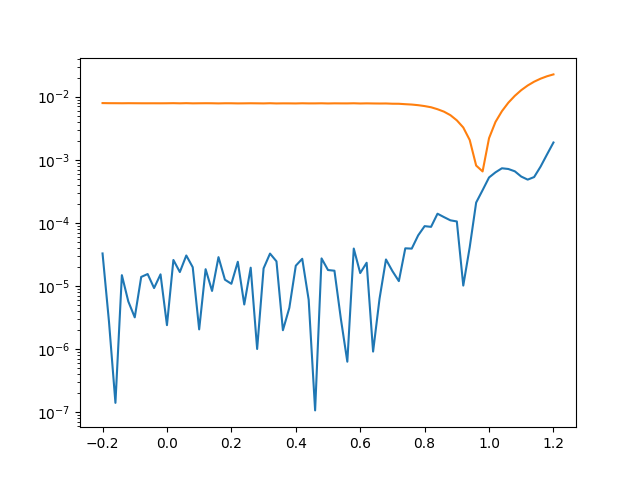

In [112]:
plt.figure()
plt.plot(V, np.abs(I-I_fit))
plt.plot(V, np.abs(I_neg-I_fit2))
plt.yscale( "log")
plt.show()

In [58]:
slice(-V[-1],-V[0],V[1]-V[0])

slice(-1.25, 0.19, 0.01999999999999999)